In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F 
import torch.optim as optim 
from sklearn.cluster import KMeans 
from sklearn.metrics import classification_report

from envs import Spiral
from learner import reach_nn

# Certificate

In [22]:
# Tunable hyperparameters for learning: eps, lr, weight_decay
EPS_TGT, EPS_DEC = 2e-1, 1e-2
LR, WEIGHT_DECAY = 1e-3, 1e-5
N_EPOCH, N_BATCH = 512, 50


def loss_tgt(cert, x_tgt, eps_tgt=EPS_TGT):
    N = len(x_tgt)
    return 1/N * torch.sum(
        torch.relu(cert(x_tgt) - eps_tgt) )


def loss_dec(cert, x_dec, eps_dec=EPS_DEC):
    f = torch.vmap(env.f)
    x_nxt = f(x_dec)
    
    N = len(x_dec)
    return 1/N * torch.sum(
        torch.relu(cert(x_nxt) - cert(x_dec) + eps_dec) )


def loss_fn(cert, x_tgt, x_dec):
    return ( 
        0.1*loss_tgt(cert, x_tgt) 
        + 1000*loss_dec(cert, x_dec)
    )


def chk_tgt_train(cert, x_tgt, eps_tgt=EPS_TGT):
    """Check for Target condition on training data."""
    v = cert(x_tgt)
    return torch.all(v <= eps_tgt)


def chk_dec_train(cert, x_dec, eps_dec=EPS_DEC):
    """Check for Decrease condition on training data."""
    v = cert(x_dec)
    vf = cert(torch.vmap(env.f)(x_dec))
    return torch.all(v - vf >= eps_dec)


def chk_train(cert, x_tgt, x_dec):
    return (
        chk_tgt_train(cert, x_tgt)
        and chk_dec_train(cert, x_dec) )


def fit_cert(cert, x_tgt, x_dec):
    tgt_ld = D.DataLoader(x_tgt, batch_size= len(x_tgt) // N_BATCH, shuffle=True)
    dec_ld = D.DataLoader(x_dec, batch_size=len(x_dec) // N_BATCH, shuffle=True)
    
    optimizer = optim.Adam(
        cert.parameters(),
        lr=LR,
        weight_decay=WEIGHT_DECAY
    )

    for e in range(N_EPOCH+1):
        epoch_loss = 0
        tgt_it, dec_it = iter(tgt_ld), iter(dec_ld)
        for b in range(N_BATCH):
            x_t, x_d = next(tgt_it), next(dec_it)
            optimizer.zero_grad()
            loss = loss_fn(cert, x_t, x_d)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        # if e % (N_EPOCH >> 2) == 0:
            # print(f'-- FIT_CERT. Epoch {e:>5}. Loss={epoch_loss:>16.6f}')

# Verification

## Using Z3

In [14]:
from z3 import *


# All the functions defined in this cell are re-definitions of 
# existing functions, but re-defined so that they can be used 
# in combination with an SMT solver (e.g., Z3).

def ReLU(x): return If(x >= 0 , x, 0)
def Abs (x): return If(x >= 0, x, -x)


def V(x):
    ReLU_ = np.vectorize(ReLU)
    y1 = w1 @ x + b1
    z1 = ReLU_(y1)
    y2 = w2 @ z1 + b2
    z2 = ReLU_(y2)
    y3 = w3 @ z2 + b3
    z3 = ReLU_(y3)
    return y3


def F(x):
    a, b = env.alpha, env.beta
    A = np.array( [
      [ a,  b], 
      [-b,  a]
    ] )
    return A @ x


def cex(C, x):
    """List of counter-examples to C.
    
    Args:
      C: A list of Z3 constraints.
    """
    s = Solver()
    s.add(C)
    chk = s.check()
    # print(f'CEX. chk={chk}')
    if chk == sat:
        m = s.model()
        n = len(x)
        return [ float(m[x[i]].as_fraction()) for i in range(n) ]
    elif chk == unsat:
        return None
    else:
        assert False, 'unknown result for SMT query'


def chk_dec(x):
    """Verification task for the Decrease condition."""
    # print('CHK_DEC. Setting up the problem ...')
    domain = []
    domain += [Abs(x[i]) >= 0.05 for i in range(2)]
    domain += [Abs(x[i]) <= 1.00 for i in range(2)]
    
    problem = []
    V_x = V(x)
    VF_x = V(F(x))
    problem.append(v  == V_x [0])
    problem.append(vf == VF_x[0])
    problem.append(v - vf < EPS_DEC)

    return cex(domain + problem, x)


def chk_tgt(x):
    """Verification task for the Target condition."""
    # print('CHK_TGT. Setting up the problem ...')
    domain = [Abs(x[i]) <= 0.05 for i in range(2)]
    problem = []
    V_x = V(x)
    problem.append(v == V_x[0])
    problem.append(v  > EPS_TGT)
    
    return cex(domain + problem, x)

# CEGIS Loop

In [24]:
MAX_CEGIS_ITER = 10
MAX_TRAIN_ITER = 10

env = Spiral(alpha=0.6, beta=0.7)
X = torch.rand(10000, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(X[:,0]) <= 0.05,
    torch.abs(X[:,1]) <= 0.05, )
X_tgt = torch.rand(500, 2)*0.1 - 0.05
X_dec = X[~tgt_mask]

for i in range(MAX_CEGIS_ITER):
    print(f'CEGIS. Iter. {i:>2}')
    print(f'CEGIS. |X_tgt|={len(X_tgt)}, |X_dec|={len(X_dec)}')
    cert = None
    for i in range(MAX_TRAIN_ITER):
        # print(f'CEGIS. Train iter. {i:>2}')
        cert = reach_nn()
        fit_cert(cert, X_tgt, X_dec)
        if chk_train(cert, X_tgt, X_dec): 
            print(f'CEGIS. Cert found on iter. {i}')
            break
    if not cert:
        raise RuntimeError('Target or Decrease condition failed.')
    
    x = np.array(RealVector('x', 2))
    w1, w2, w3 = [
        cert.layers[i].weight.data.numpy() for i in range(3)]
    b1, b2, b3 = [
        cert.layers[i].  bias.data.numpy() for i in range(3)]
    v, vf = Real('v'), Real('vf')
    cex_tgt = chk_tgt(x)
    cex_dec = chk_dec(x)
    print(f'CEGIS. CEx-s. Tgt={cex_tgt}, Dec={cex_dec}')
    if cex_tgt:
        X_tgt = torch.vstack([X_tgt, torch.Tensor(cex_tgt)])
    if cex_dec: 
        X_dec = torch.vstack([X_dec, torch.Tensor(cex_dec)])
    if not cex_tgt and not cex_dec:
        print('CEGIS. Cert found.')
        break

CEGIS. Iter.  0
CEGIS. |X_tgt|=500, |X_dec|=9971
CEGIS. Cert found on iter. 3
CEGIS. CEx-s. Tgt=None, Dec=None
CEGIS. Cert found.


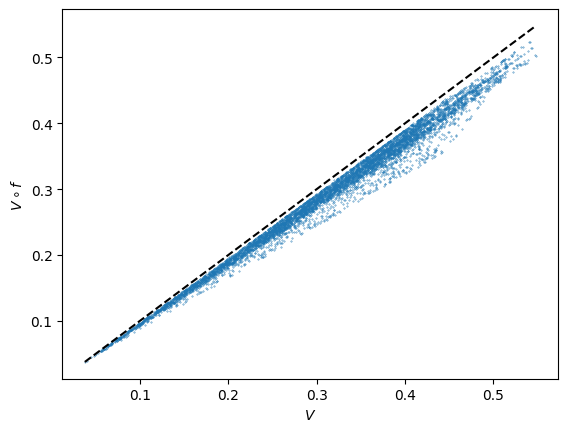

In [5]:
v  = cert(x)
vf = cert(torch.vmap(env.f)(x))
v, vf = v.detach(), vf.detach()

plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'k--')
plt.scatter(v, vf, s=0.1)
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ f$')
plt.show()

v = cert(x_dec)
vf = cert(torch.vmap(env.f)(x_dec))
assert torch.all(v > vf), 'Decrease condition negated on training data'

# Partitioning

## Heuristic: Strengthened Decrease Condition

In [16]:
def partition(x, y):
    N = len(x)
    P = []
    
    for i in range(N):
        print(f'i={i}. P={P}')
        # idx is the lowest value where v(f(x[i])) < v[x[idx]]
        _, idx = binary_search(
            P, len(P), lambda p: y[i] >= p[0][0])
        print(f'  idx={idx}')
        if idx == len(P):
            P.append( [(x[i], y[i])] )
        else:
            P[idx].append( (x[i], y[i]) )
    return x, P

x = [2,   3, 4,   5,    6, 7]
y = [1, 1.5, 3, 1.75, 3.5, 5]

x, P = partition(x, y)
print(f'P={P}')

i=0. P=[]
  idx=0
i=1. P=[[(2, 1)]]
  idx=0
i=2. P=[[(2, 1), (3, 1.5)]]
  idx=1
i=3. P=[[(2, 1), (3, 1.5)], [(4, 3)]]
  idx=0
i=4. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3)]]
  idx=1
i=5. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)]]
  idx=2
P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)], [(7, 5)]]


In [136]:
def binary_search(a, n, f):
    """Binary search with a given condition f.
    
    Returns: 
      l: highest value for i where f[i] holds.
      r: lowest  value for i where f[i] does not hold.
    """
    l, r = -1, n
    while r-l > 1:
        m = (l+r) >> 1
        if f(a[m]):
            l = m
        else:
            r = m
    return l, r


def partition(x: torch.Tensor, v, f):
    # Assumption. The learned certificate does not violate the 
    # decrease condition on any of the states given in x.
    f_vmap = torch.vmap(f)
    assert torch.all(v(x) > v(f_vmap(x)))
    
    _, sort_idx = torch.sort(v(x), dim=0)
    # Sort x such that (i < j) <=> v(x[i]) < v(x[j])
    x = x[sort_idx]
    # Remove extra dimensions of size 1 that come from 
    # picking certain indices of x.
    # After this step, x should be a Nx2 matrix.
    x = torch.squeeze(x)
    
    # A list of all partitions.
    # For each partition p, p[0] is the _representative_ of p.
    # This property of the partitions enables us to use binary 
    # search when choosing an existing partition for a new point.
    P = []
    for i in range(len(x)):
        # idx is the first existing partition to which we can 
        # add x[i].
        _, idx = binary_search(
            P, len(P), lambda p: v(f(x[i])) >= v(p[0]))
        if idx == len(P): 
            # x[i] cannot be added to any of the existing partitions,
            # so we need to create its own partition.
            P.append( [x[i]] )
        else:
            P[idx].append(x[i])
    return x, P


_, P = partition(x_dec, cert, env.f)
print(f'|P|={len(P)}')

|P|=67


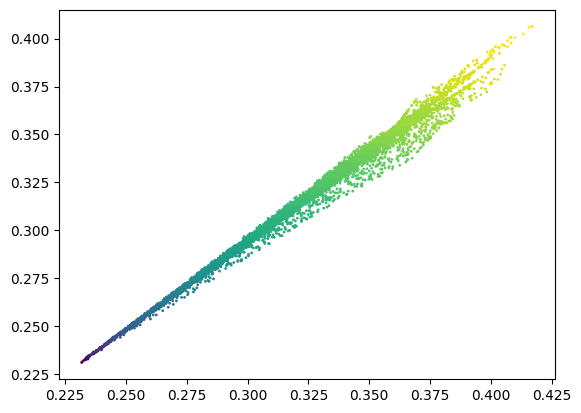

In [137]:
f_vec = torch.vmap(env.f)

x_dec1, v, vf, c = [], [], [], []
for i, p in enumerate(P):
    x_p = torch.vstack(p)
    x_dec1.append(x_p)
    v.append(cert(x_p).detach())
    vf.append(cert(f_vec(x_p)).detach())
    c.append(torch.ones(len(x_p))*i)

x_dec1 = torch.vstack(x_dec1)
v = torch.vstack(v)
vf = torch.vstack(vf)
c = torch.cat(c)

plt.scatter(v, vf, c=c, s=1)
plt.show()

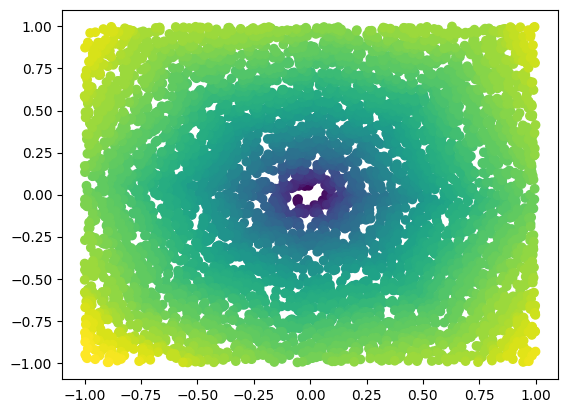

In [138]:
plt.scatter(x_dec1[:,0], x_dec1[:,1],c=c)
plt.show()

In [139]:
SZ_P = len(P)
part = nn.Sequential(
    nn.Linear(2, 2*SZ_P), nn.ReLU(),
    nn.Linear(2*SZ_P, SZ_P), nn.ReLU(),
)

ids, cnt = torch.unique(c, return_counts=True)
# Similar to sklearn.utils.class_weight.compute_class_weight
weight = len(x_dec1) / (SZ_P * cnt)
loss_fn = nn.CrossEntropyLoss(weight=weight)

optimizer = optim.Adam(part.parameters(), lr=1e-3, weight_decay=1e-5)

N_EPOCH, BATSZ = 1024, 100
N_BATCH = len(x_dec1) // BATSZ
print(f'BATSZ={BATSZ}')
c = c.long()
dataset = D.TensorDataset(x_dec1, c)
bat_ld = D.DataLoader(
    dataset, 
    batch_size=BATSZ, 
    shuffle=True)

for e in range(N_EPOCH+1):
    epoch_loss = 0
    bat_it = iter(bat_ld)
    for b in range(N_BATCH):
        optimizer.zero_grad()
        nxt_bat = next(bat_it)
        x_d, y = nxt_bat
        loss = loss_fn(part(x_d), y)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
        
    if e % 128 == 0:
        print(f'{e:>4}. Loss={epoch_loss:>16.6f}')

BATSZ=100
   0. Loss=      263.677246
 128. Loss=      225.069580
 256. Loss=      218.479980
 384. Loss=      212.862717
 512. Loss=      208.519791
 640. Loss=      206.038513
 768. Loss=      204.224548
 896. Loss=      199.853928
1024. Loss=      192.275497


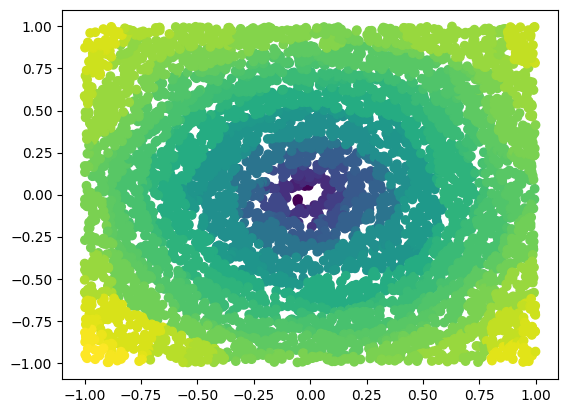

In [140]:
c_part = torch.argmax(part(x_dec1), dim=1)
plt.scatter(x_dec1[:,0], x_dec1[:,1], c=c_part)
plt.show()

In [141]:
print(classification_report(c, c_part))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.43      1.00      0.60         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.50      0.44      0.47         9
           8       0.00      0.00      0.00         6
           9       0.35      0.67      0.46        12
          10       0.29      0.46      0.35        13
          11       0.29      0.60      0.39        10
          12       0.00      0.00      0.00        11
          13       0.30      0.55      0.39        11
          14       0.00      0.00      0.00         9
          15       0.29      0.45      0.35        20
          16       0.25      0.91      0.39        11
          17       0.00    

/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahyar/anaconda3/envs/prototype/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Heuristic: $U(\mathbf{x}) = V(\mathbf{x}) - V(f(\mathbf{x}))$, Clustering

In [183]:
def knee(crv: torch.Tensor):
    """Knee point of a 2D-curve [(x1, y1), ..., (xn, yn)].
    
    We define the knee point of this curve as the point (xi, yi)
    which is the point farthest away from the line connecting 
    (x1, y1) and (xn, yn) (i.e., the line that connects the first 
    and last points in the curve).
    """
    assert len(crv.shape) == 2 and crv.shape[1] == 2
    
    # h = 2A / b
    b = (crv[0] - crv[-1]).square().sum().sqrt()
    # print(f'b={b}')

    x1, y1 = crv[0]
    xn, yn = crv[-1]
    idx_knee, h_knee = 0, 0.0
    for i, (xi, yi) in enumerate(crv):
        h = torch.abs((xn - x1)*(y1 - yi) - (yn - y1)*(x1 - xi)) / b
        # print(f'i={i:>2}, h[{i}]={h:>8.6f}')
        if h < h_knee:
            continue
        idx_knee, h_knee = i, h
    return idx_knee


curve = torch.Tensor([
    [0, 0],
    [1, 1],
    [2, 3],
    [3, 2],
    [4, 1],
    [5, 0],
])

assert knee(curve) == 2

Knee. k=8


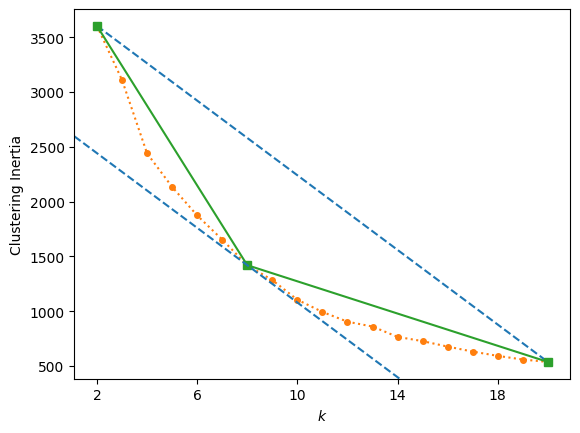

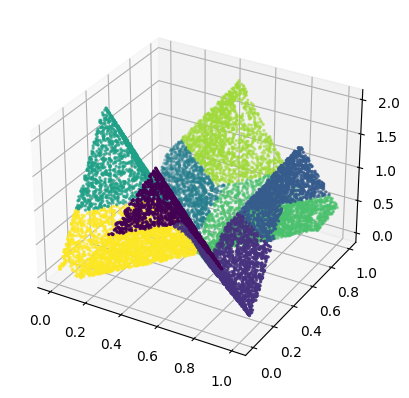

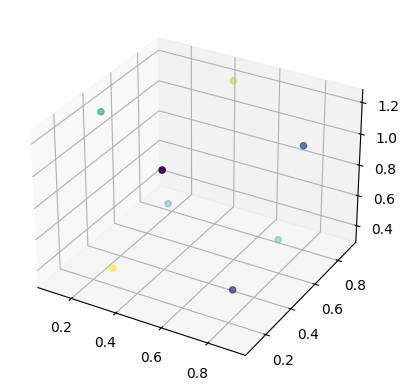

In [236]:
f_vec = torch.vmap(env.f)
dec = cert(x) - cert(f_vec(x))
p = torch.hstack(
    (x, dec.detach())
)

# Dimension normalization 
p_min, p_max = p.min(dim=0).values, p.max(dim=0).values
p = (p - p_min) / (p_max - p_min)
p[:, -1] *= 2
# p[:, -1] += 1000

curve = []
for k in range(2,20+1):
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(p)
    curve.append( (k, kmeans.inertia_) )
curve = torch.Tensor(curve)

k = knee(curve)
print(f'Knee. k={2+k}')

plt.figure()
x1, y1 = curve[0]
xn, yn = curve[-1]
plt.plot([x1, xn], [y1, yn], '--')
plt.plot(curve[:,0], curve[:,1], ':o', markersize=4)
xk, yk = curve[k]
plt.plot([x1, xk, xn], [y1, yk, yn], '-s')
plt.xticks(range(2,21,4))
plt.axline((xk, yk), slope=(y1-yn)/(x1-xn), linestyle='dashed')
plt.xlabel(r'$k$')
plt.ylabel('Clustering Inertia')

kmeans = KMeans(n_clusters=2+k, n_init='auto').fit(p)
# p[:,-1] /= 2
## p[:,-1] -= 1000
# p = p * (p_max - p_min) + p_min
cs = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2], c=kmeans.labels_, s=2)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cs[:,0], cs[:,1], cs[:,2], c=range(2+k))
plt.show()

## Using PySMT

In [116]:
from pysmt.shortcuts import Symbol, And, Ite, GE, Real, Times
from pysmt.typing import REAL


def Abs(x):
    iff = GE(x, Real(0))
    left = x 
    right = Times([Real(-1), x])
    return Ite(iff, left, right)


x = np.array([Symbol(f'x{i}', REAL) for i in range(2)])
domains = [GE(Abs(x[i]), Real(0.05)) for i in range(2)]
domains = And(domains)

In [4]:
env  = Spiral(alpha=0.6, beta=0.7)
cert = reach_nn()  # Certificate NN.

x = torch.rand(6400, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05, )
x_tgt = torch.rand(400, 2)*0.1 - 0.05
x_dec = x[~tgt_mask]
print(f'|x_tgt|={len(x_tgt)}, |x_dec|={len(x_dec)}')

fit_cert(cert, x_tgt, x_dec)

|x_tgt|=400, |x_dec|=6387
